## Overview
This tutorial has been prepared by Alex Bonnet, ML Solutions Engineer @ Encord - you might also be interested in checking out our open-source framework for computer vision model testing, evaluation, and validation that you can find here https://github.com/encord-team/encord-active).

This is the notebook which implements the steps discussed in this blog post: https://encord.com/blog/learn-how-to-fine-tune-the-segment-anything-model-sam/

The aim is to take Segment Anything Model and fine tune it to a specific application. We are going to be using the stamp verification dataset https://www.kaggle.com/datasets/rtatman/stamp-verification-staver-dataset since it has data SAM is unlikely to have seen (scans of invoices with stamps), has precise ground truth segmentation masks and also has bounding boxes which we can use as prompts to SAM.

## Set up

In [ ]:
! pip install kaggle &> /dev/null
! pip install torch torchvision &> /dev/null
! pip install opencv-python pycocotools matplotlib onnxruntime onnx &> /dev/null
! pip install git+https://github.com/facebookresearch/segment-anything.git &> /dev/null
! wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth &> /dev/null

**Action Required:** Place your kaggle.json file into the files in the notebook workspace. More info here https://github.com/Kaggle/kaggle-api#api-credentials

In [1]:
! mkdir ~/.kaggle
! mv kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

mv: 无法获取'kaggle.json' 的文件状态(stat): 没有那个文件或目录
chmod: 无法访问 '/home/yjl/.kaggle/kaggle.json': 没有那个文件或目录


In [ ]:
! kaggle datasets download rtatman/stamp-verification-staver-dataset

In [ ]:
! unzip stamp-verification-staver-dataset.zip &> /dev/null

In [1]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [2]:
# Exclude scans with zero or multiple bboxes (of the first 100)
stamps_to_exclude = {
    'stampDS-00008',
    'stampDS-00010',
    'stampDS-00015',
    'stampDS-00021',
    'stampDS-00027',
    'stampDS-00031',
    'stampDS-00039',
    'stampDS-00041',
    'stampDS-00049',
    'stampDS-00053',
    'stampDS-00059',
    'stampDS-00069',
    'stampDS-00073',
    'stampDS-00080',
    'stampDS-00090',
    'stampDS-00098',
    'stampDS-00100'
}.union({
    'stampDS-00012',
    'stampDS-00013',
    'stampDS-00014',
}) # Exclude 3 scans that aren't the type of scan we want to be fine tuning for

## Preprocess data

We extract the bounding box coordinates which will be used to feed into SAM as prompts.

In [3]:
bbox_coords = {}
for f in sorted(Path('ground-truth-maps/ground-truth-maps/').iterdir())[:100]:
  k = f.stem[:-3]
  if k not in stamps_to_exclude:
    im = cv2.imread(f.as_posix())
    gray=cv2.cvtColor(im,cv2.COLOR_BGR2GRAY)
    contours, hierarchy = cv2.findContours(gray,cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)[-2:]
    if len(contours) > 1:
      x,y,w,h = cv2.boundingRect(contours[0])
      height, width, _ = im.shape
      bbox_coords[k] = np.array([x, y, x + w, y + h])

We extract the ground truth segmentation masks

In [4]:
ground_truth_masks = {}
for k in bbox_coords.keys():
  gt_grayscale = cv2.imread(f'ground-truth-pixel/ground-truth-pixel/{k}-px.png', cv2.IMREAD_GRAYSCALE)
  ground_truth_masks[k] = (gt_grayscale == 0)

## Take a look at the images, the bounding box prompts and the ground truth segmentation masks

In [5]:
# Helper functions provided in https://github.com/facebookresearch/segment-anything/blob/9e8f1309c94f1128a6e5c047a10fdcb02fc8d651/notebooks/predictor_example.ipynb
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))

We can see here that the ground truth mask is extremely tight which will be good for calculating an accurate loss.
The bounding box overlaid will be a good prompt.

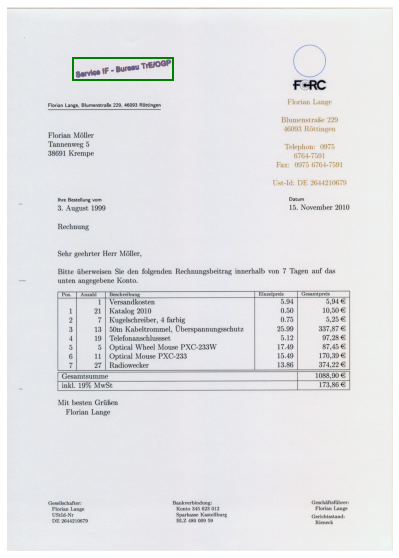

In [ ]:
name = 'stampDS-00004'
image = cv2.imread(f'scans/scans/{name}.png')

plt.figure(figsize=(10,10))
plt.imshow(image)
show_box(bbox_coords[name], plt.gca())
show_mask(ground_truth_masks[name], plt.gca())
plt.axis('off')
plt.show()

## Prepare Fine Tuning

In [7]:
model_type = 'vit_b'
checkpoint = '../pretrained_checkpoint/sam_vit_b_01ec64.pth'
device = 'cuda:0'

In [8]:
from segment_anything import SamPredictor, sam_model_registry
sam_model = sam_model_registry[model_type](checkpoint=checkpoint)
sam_model.to(device)
sam_model.train();

We convert the input images into a format SAM's internal functions expect.

In [9]:
# Preprocess the images
from collections import defaultdict

import torch

from segment_anything.utils.transforms import ResizeLongestSide

transformed_data = defaultdict(dict)
for k in bbox_coords.keys():
  image = cv2.imread(f'scans/scans/{k}.png')
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  transform = ResizeLongestSide(sam_model.image_encoder.img_size)
  input_image = transform.apply_image(image)
  input_image_torch = torch.as_tensor(input_image, device=device)
  transformed_image = input_image_torch.permute(2, 0, 1).contiguous()[None, :, :, :]

  input_image = sam_model.preprocess(transformed_image)
  original_image_size = image.shape[:2]
  input_size = tuple(transformed_image.shape[-2:])

  transformed_data[k]['image'] = input_image
  transformed_data[k]['input_size'] = input_size
  transformed_data[k]['original_image_size'] = original_image_size

In [10]:
# Set up the optimizer, hyperparameter tuning will improve performance here
lr = 1e-4
wd = 0
optimizer = torch.optim.Adam(sam_model.mask_decoder.parameters(), lr=lr, weight_decay=wd)

loss_fn = torch.nn.MSELoss()
# loss_fn = torch.nn.BCELoss()
keys = list(bbox_coords.keys())

## Run fine tuning

This is the main training loop.

Improvements to be made include batching and moving the computation of the image and prompt embeddings outside the loop since we are not tuning these parts of the model, this will speed up training as we should not recompute the embeddings during each epoch. Sometimes the optimizer gets lost in the parameter space and the loss function blows up. Restarting from scratch (including running all cells below 'Prepare Fine Tuning' in order to start with default weights again) will solve this.

In a production implementation a better choice of optimiser/loss function will certainly help.

In [11]:
from statistics import mean

from tqdm import tqdm
from torch.nn.functional import threshold, normalize

num_epochs = 100
losses = []

for epoch in range(num_epochs):
  epoch_losses = []
  # Just train on the first 20 examples
  for k in keys[:20]:
    input_image = transformed_data[k]['image'].to(device)
    input_size = transformed_data[k]['input_size']
    original_image_size = transformed_data[k]['original_image_size']

    # No grad here as we don't want to optimise the encoders
    with torch.no_grad():
      image_embedding = sam_model.image_encoder(input_image)

      prompt_box = bbox_coords[k]
      box = transform.apply_boxes(prompt_box, original_image_size)
      box_torch = torch.as_tensor(box, dtype=torch.float, device=device)
      box_torch = box_torch[None, :]

      sparse_embeddings, dense_embeddings = sam_model.prompt_encoder(
          points=None,
          boxes=box_torch,
          masks=None,
      )
    low_res_masks, iou_predictions = sam_model.mask_decoder(
      image_embeddings=image_embedding,
      image_pe=sam_model.prompt_encoder.get_dense_pe(),
      sparse_prompt_embeddings=sparse_embeddings,
      dense_prompt_embeddings=dense_embeddings,
      multimask_output=False,
    )

    upscaled_masks = sam_model.postprocess_masks(low_res_masks, input_size, original_image_size).to(device)
    binary_mask = normalize(threshold(upscaled_masks, 0.0, 0))

    gt_mask_resized = torch.from_numpy(np.resize(ground_truth_masks[k], (1, 1, ground_truth_masks[k].shape[0], ground_truth_masks[k].shape[1]))).to(device)
    gt_binary_mask = torch.as_tensor(gt_mask_resized > 0, dtype=torch.float32)

    loss = loss_fn(binary_mask, gt_binary_mask)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    epoch_losses.append(loss.item())
  losses.append(epoch_losses)
  print(f'EPOCH: {epoch}')
  print(f'Mean loss: {mean(epoch_losses)}')

EPOCH: 0
Mean loss: 0.0012898923305328935
EPOCH: 1
Mean loss: 0.0012739748024614527
EPOCH: 2
Mean loss: 0.0010814871231559664
EPOCH: 3
Mean loss: 0.0010436763419420458
EPOCH: 4
Mean loss: 0.0010475359347765334
EPOCH: 5
Mean loss: 0.0010591546597424895
EPOCH: 6
Mean loss: 0.001070174497726839
EPOCH: 7
Mean loss: 0.0011654800531687216
EPOCH: 8
Mean loss: 0.0012162537808762864
EPOCH: 9
Mean loss: 0.0012194079987239092
EPOCH: 10
Mean loss: 0.0012101582862669602
EPOCH: 11
Mean loss: 0.0012026520271319896
EPOCH: 12
Mean loss: 0.0012046483607264236
EPOCH: 13
Mean loss: 0.001218210204388015
EPOCH: 14
Mean loss: 0.0012267811718629674
EPOCH: 15
Mean loss: 0.001222429156769067
EPOCH: 16
Mean loss: 0.0012129797687521204
EPOCH: 17
Mean loss: 0.0012086011207429691
EPOCH: 18
Mean loss: 0.0012083216424798593
EPOCH: 19
Mean loss: 0.0012096126069081948
EPOCH: 20
Mean loss: 0.0011987391859292983
EPOCH: 21
Mean loss: 0.0011876661097630858
EPOCH: 22
Mean loss: 0.0011344036203809083
EPOCH: 23
Mean loss: 0.0

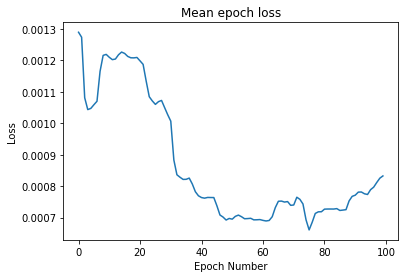

In [13]:
mean_losses = [mean(x) for x in losses]
mean_losses

plt.plot(list(range(len(mean_losses))), mean_losses)
plt.title('Mean epoch loss')
plt.xlabel('Epoch Number')
plt.ylabel('Loss')

plt.show()

## We can compare our tuned model to the original model

In [14]:
# Load up the model with default weights
sam_model_orig = sam_model_registry[model_type](checkpoint=checkpoint)
sam_model_orig.to(device);

In [15]:
# Set up predictors for both tuned and original models
from segment_anything import sam_model_registry, SamPredictor
predictor_tuned = SamPredictor(sam_model)
predictor_original = SamPredictor(sam_model_orig)

In [16]:
# The model has not seen keys[21] (or keys[20]) since we only trained on keys[:20]
k = keys[21]
image = cv2.imread(f'scans/scans/{k}.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

predictor_tuned.set_image(image)
predictor_original.set_image(image)

input_bbox = np.array(bbox_coords[k])

masks_tuned, _, _ = predictor_tuned.predict(
    point_coords=None,
    box=input_bbox,
    multimask_output=False,
)

masks_orig, _, _ = predictor_original.predict(
    point_coords=None,
    box=input_bbox,
    multimask_output=False,
)

We can see here that the tuned model is starting to ignore the whitespace between the words, which is what the ground truths show. With further training, more data and further hyperparameter tuning we will be able to improve this result.

If the image does not render due to size limitations, you can view it here https://drive.google.com/file/d/1ip5aryaxcp8JcEaZubL76oOM6srVzKsc/view?usp=sharing .

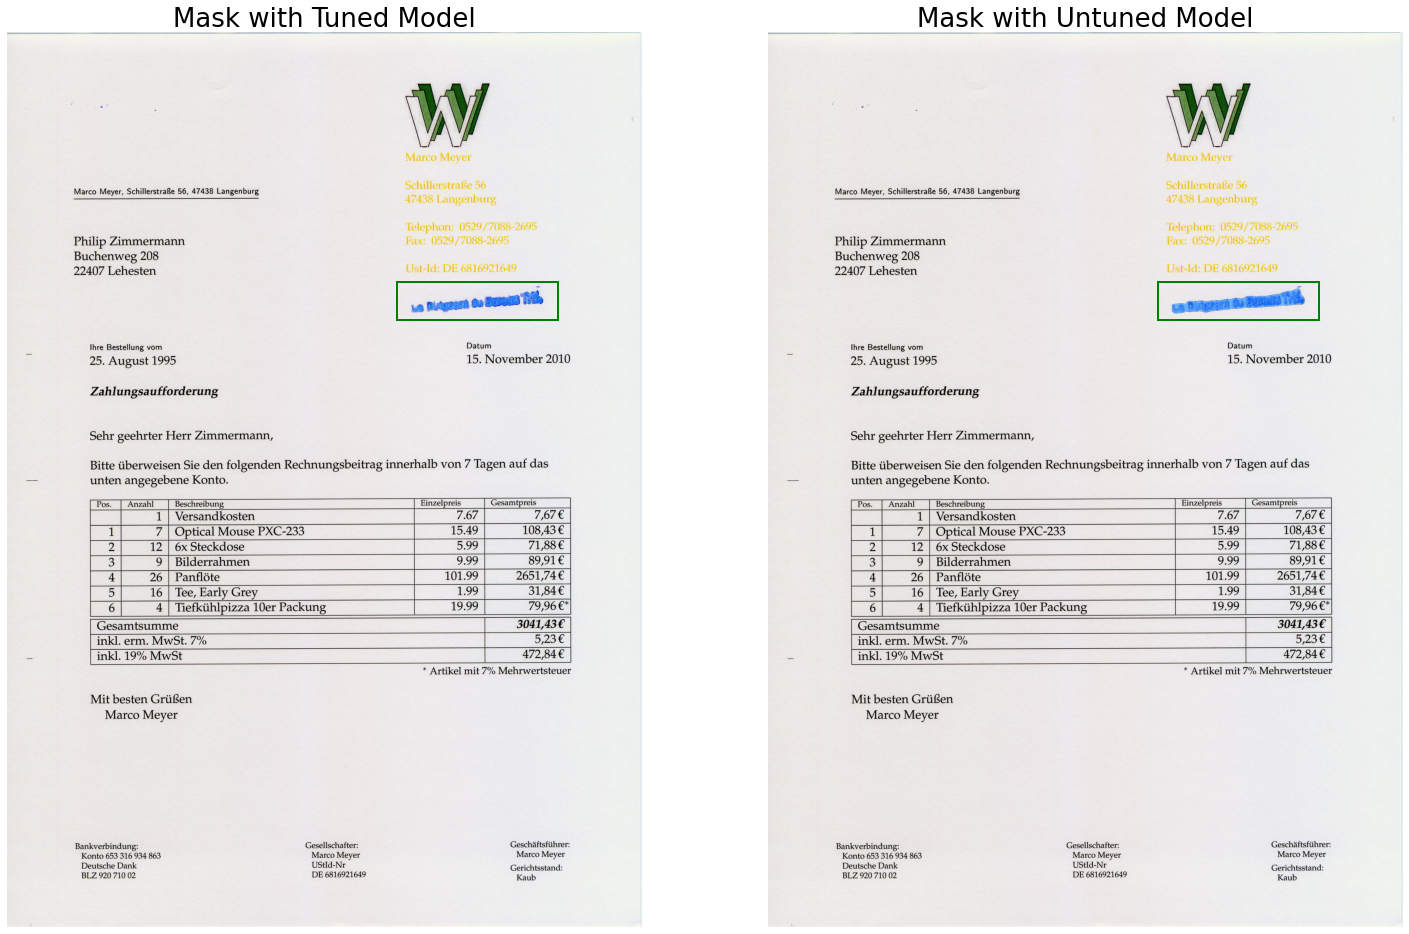

In [17]:
%matplotlib inline
_, axs = plt.subplots(1, 2, figsize=(25, 25))


axs[0].imshow(image)
show_mask(masks_tuned, axs[0])
show_box(input_bbox, axs[0])
axs[0].set_title('Mask with Tuned Model', fontsize=26)
axs[0].axis('off')


axs[1].imshow(image)
show_mask(masks_orig, axs[1])
show_box(input_bbox, axs[1])
axs[1].set_title('Mask with Untuned Model', fontsize=26)
axs[1].axis('off')

plt.show()